# **RM Project**
to download SPX data use [this link](https://finance.yahoo.com/quote/%5EGSPC/history?period1=1420070400&period2=1462060800&interval=1d&filter=history&frequency=1d)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
sns.set_style("white")
import altair as alt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
alt.data_transformers.enable('default', max_rows=None) 

DataTransformerRegistry.enable('default')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

parent_path = r'gdrive/My Drive/RM_Project/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.listdir(parent_path)

['OptionPrices_2015_m1_m6.csv',
 'OptionPrices_2015_m7_m12.csv',
 'OptionPrices_2016.csv',
 'SP500_20150101-20160501.csv']

In [0]:
# import sys

# local_vars = list(locals().items())
# for var, obj in local_vars:
#     print(var, sys.getsizeof(obj))
#     print(var)

In [0]:
def convert_to_datetime(df):
  df.date = pd.to_datetime(df.date.astype('Int64').astype(str), format='%Y-%m-%d')
  df.exdate = pd.to_datetime(df.exdate.astype('Int64').astype(str), format='%Y-%m-%d')
  # df.last_date = pd.to_datetime(df.astype('Int64').last_date.astype(str), format='%Y-%m-%d')
  return df

def read_files(path):
  headers = pd.read_csv(os.path.join(path, 'OptionPrices_2016.csv'), nrows=1).columns
  df = pd.DataFrame(columns=headers)

  for file_name in os.listdir(path):
    if file_name != 'SP500_20150101-20160501.csv':
      df = df.append(pd.read_csv(os.path.join(path, file_name)))
    else:
      dtypes = {'Date': 'str', 'Open' : 'float64', 'High': 'float64', 
                'Low': 'float64', 'Close': 'float64', 'Adj Close': 'float64', 'Volume' : 'int64'}
      headers = ['date', 'sp_open', 'sp_high', 'sp_low', 'sp_close', 'sp_adj_close', 'sp_volume']
      df_sp = pd.read_csv(os.path.join(path, file_name), dtype=dtypes, names=headers, skiprows=1)
      df_sp.date = df_sp.date.str.replace('-', '').astype(np.int64)
  df.date = df.date.astype(np.int64)
  df = pd.merge(df, df_sp, on='date', how='left')
  df = convert_to_datetime(df)

  return df

# 1. Data Exploration / Visualization

In [0]:
df_options = read_files(parent_path)
df_options.strike_price /= 1000

df_options.columns

Index(['secid', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date',
       'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'optionid', 'cfadj', 'ss_flag', 'root', 'suffix', 'cusip', 'ticker',
       'sic', 'index_flag', 'exchange_d', 'class', 'issue_type',
       'industry_group', 'issuer', 'div_convention', 'exercise_style',
       'am_set_flag', 'sp_open', 'sp_high', 'sp_low', 'sp_close',
       'sp_adj_close', 'sp_volume'],
      dtype='object')

([<matplotlib.axis.XTick at 0x7f345d2d29e8>,
 <a list of 17 Text major ticklabel objects>)

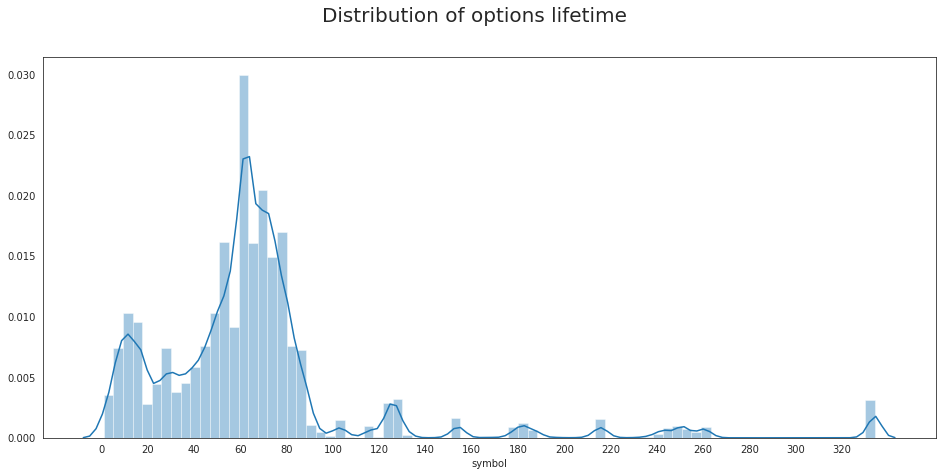

In [0]:
optionid_distrib = df_options.groupby('optionid').count().symbol

plt.figure(figsize=(16,7))
sns.distplot(optionid_distrib, bins=80)
plt.suptitle('Distribution of options lifetime', fontsize=20)

xmarks=[i for i in range(0,optionid_distrib.max()+1,20)]
plt.xticks(xmarks)



Text(0.5, 0.98, 'S&P 500 Index price')

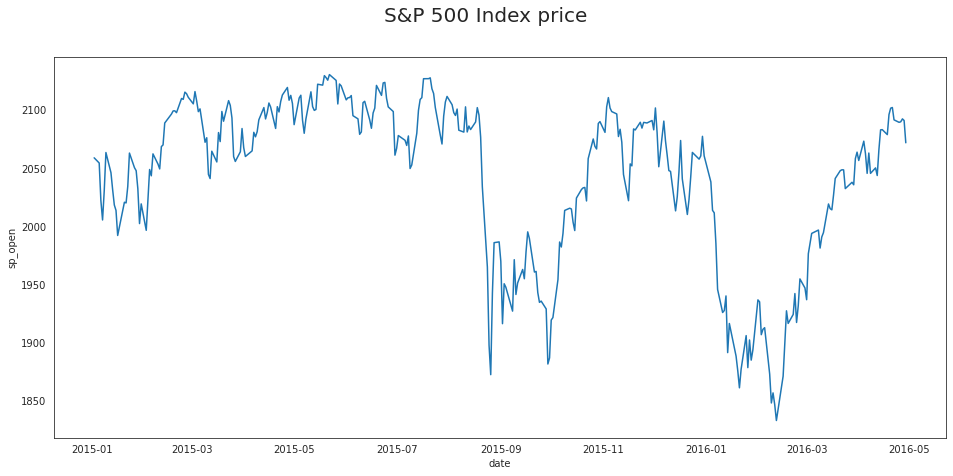

In [0]:
sp_price = df_options.drop_duplicates(['date'])[['date','sp_open']]
plt.figure(figsize=(16,7))
sns.lineplot(x='date', y='sp_open', data=sp_price)
plt.suptitle('S&P 500 Index price', fontsize=20)
# alt.Chart(sp_price).mark_line().encode(
#     alt.X('date:O', format='timeUnit', #timeUnit='month'
#           axis = alt.Axis(values=['2015-01-02','2015-01-02','2015-03-02','2015-06-02','2015-09-02','2016-01-02'])
#           ),
#     alt.Y('sp_open:Q', scale=alt.Scale(domain=[sp_price.sp_open.min()-10, sp_price.sp_open.max()+10]))
   
# ).properties(width = 800, height = 300)

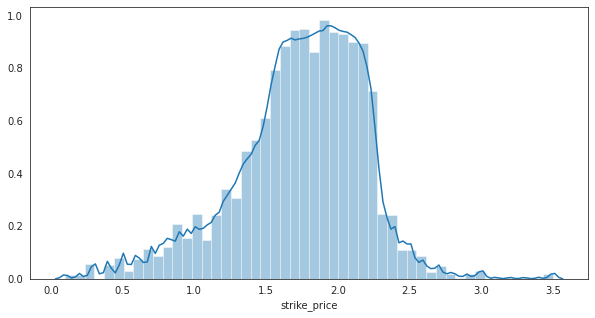

In [0]:
plt.figure(figsize=(10,5))
sns.distplot(df_options.strike_price/1000)

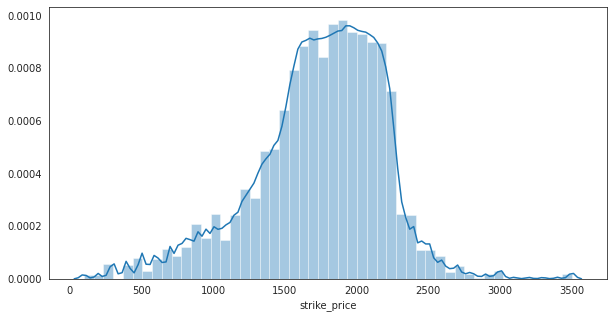

In [0]:
plt.figure(figsize=(10,5))
sns.distplot(df_options.strike_price)

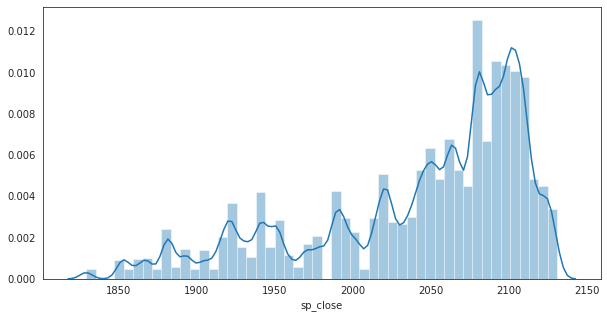

In [0]:
plt.figure(figsize=(10,5))
sns.distplot(df_options.sp_close)

## Additional metrics

### Moneyness (`mness`)

In [0]:
df_options['mness'] = np.log((df_options.strike_price/df_options.sp_open).astype('float64')) / \
  (df_options.impl_volatility * np.sqrt((df_options.exdate-df_options.date).dt.days))

#without normalization
df_options['mness_new'] = np.log((df_options.strike_price/df_options.sp_open).astype('float64'))

In [0]:
plt.figure(figsize=(16,7))
# f, ax = plt.subplots(1, 1)
sns.distplot(df_options.mness, label="normalized", legend="full")
sns.distplot(df_options.mness_new, label='not normalized')
# ax.legend()


TypeError: ignored

<Figure size 1152x504 with 0 Axes>

### Option return

In [0]:
df_options.head()

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,ss_flag,root,suffix,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,sp_open,sp_high,sp_low,sp_close,sp_adj_close,sp_volume,mness,mness_new,op_returns
0,108105,2015-01-02,SPX 150117C100000,1,2015-01-17,20141211.0,C,100,1956.4,1959.6,0,5356,NaN,NaN,NaN,NaN,NaN,101234071,1,0,NaN,NaN,64881510,SPX,9999,1,32768,NaN,A,NaN,CBOE S&P 500 INDEX,I,E,1,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,NaN,-3.024757,-0.051066
1,108105,2015-01-02,SPX 150117C1000000,1,2015-01-17,20150102.0,C,1000,1056.7,1059.9,1500,41884,1.598836,0.993924,0.000025,6.129817,-106.8756,101234072,1,0,NaN,NaN,64881510,SPX,9999,1,32768,NaN,A,NaN,CBOE S&P 500 INDEX,I,E,1,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,-0.116625,-0.722172,-0.667021
2,108105,2015-01-02,SPX 150117C1025000,1,2015-01-17,NaN,C,1025,1031.7,1034.9,0,0,1.548044,0.993750,0.000027,6.301258,-106.2719,101234073,1,0,NaN,NaN,64881510,SPX,9999,1,32768,NaN,A,NaN,CBOE S&P 500 INDEX,I,E,1,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,-0.116333,-0.697479,-0.690964
3,108105,2015-01-02,SPX 150117C1050000,1,2015-01-17,20141124.0,C,1050,1006.7,1009.8,0,52,1.490611,0.993763,0.000028,6.288624,-100.9630,101234074,1,0,NaN,NaN,64881510,SPX,9999,1,32768,NaN,A,NaN,CBOE S&P 500 INDEX,I,E,1,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,-0.116641,-0.673382,-0.715494
4,108105,2015-01-02,SPX 150117C1075000,1,2015-01-17,20141218.0,C,1075,981.7,984.8,0,4,1.442373,0.993581,0.000030,6.466455,-100.3467,101234075,1,0,NaN,NaN,64881510,SPX,9999,1,32768,NaN,A,NaN,CBOE S&P 500 INDEX,I,E,1,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,-0.116330,-0.649851,-0.740641


In [0]:
df_options['op_returns'] = np.log(df_options.best_bid) - np.log(df_options.sp_open)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [0]:
# df_options.op_returns.describe()

## Data Cleaning

In [0]:
# Remove observations with negative bid-prices
df_options = df_options[df_options.best_bid - df_options.best_offer <= 0]

In [0]:
# Delete those observations with missing information for contract implied 
# volatility
df_options = df_options[~df_options.impl_volatility.isnull()]

In [0]:
max(df_options.impl_volatility.unique())

2.999362

In [0]:
# Delete contracts with a zero observation for open interest, i.e. the
# number of open positions in the option contract
df_options = df_options[df_options.open_interest != 0]

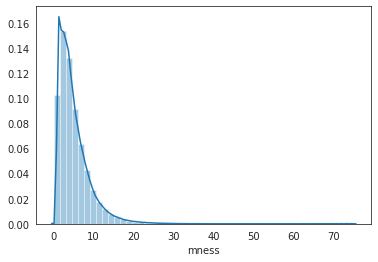

In [0]:
sns.distplot(df_options.mness)

In [0]:
# Limit the moneyness range to 0 to 2 for call options and -2.5 to 0 for
# put options
# df_options.cp_flag.unique()
df_options[
          #  ((df_options.cp_flag == 'C') & (df_options.mness >= 0) & (df_options.mness <= 2))  
           ((df_options.cp_flag == 'P') & (df_options.mness >= -2.5) & (df_options.mness <= 0))
           ]

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,ss_flag,root,suffix,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,sp_open,sp_high,sp_low,sp_close,sp_adj_close,sp_volume,ttm,op_returns,mness
